In [1]:
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


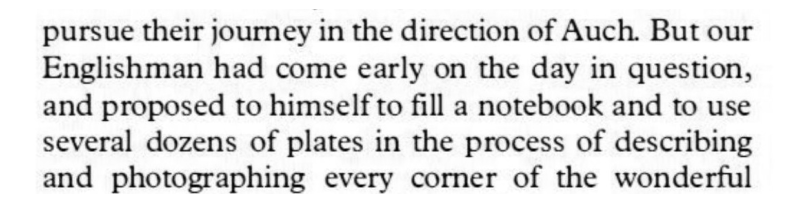

In [56]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# read the image, check if its 3 channel or grayscale, based on 
# that convert to grayscale
img = imread("test_image1.jpg")
if img.ndim > 2: # is this is a rgb/rgba image
    img = rgb2gray(img)

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show() # preview





### Find the Horizontal projection profile and find the window where line segment can be created.
One of the common ways of finding the line-height of a document is by analyzing its Horizontal projection profile.  Horizontal projection profile (HPP) is the array of sum or rows of a two dimentional image. Where there are more white spaces we see more peaks. These peaks give us an idea of where the segmentation between two lines can be done.

Before we run the project we should also threshold the image to clean all noise.

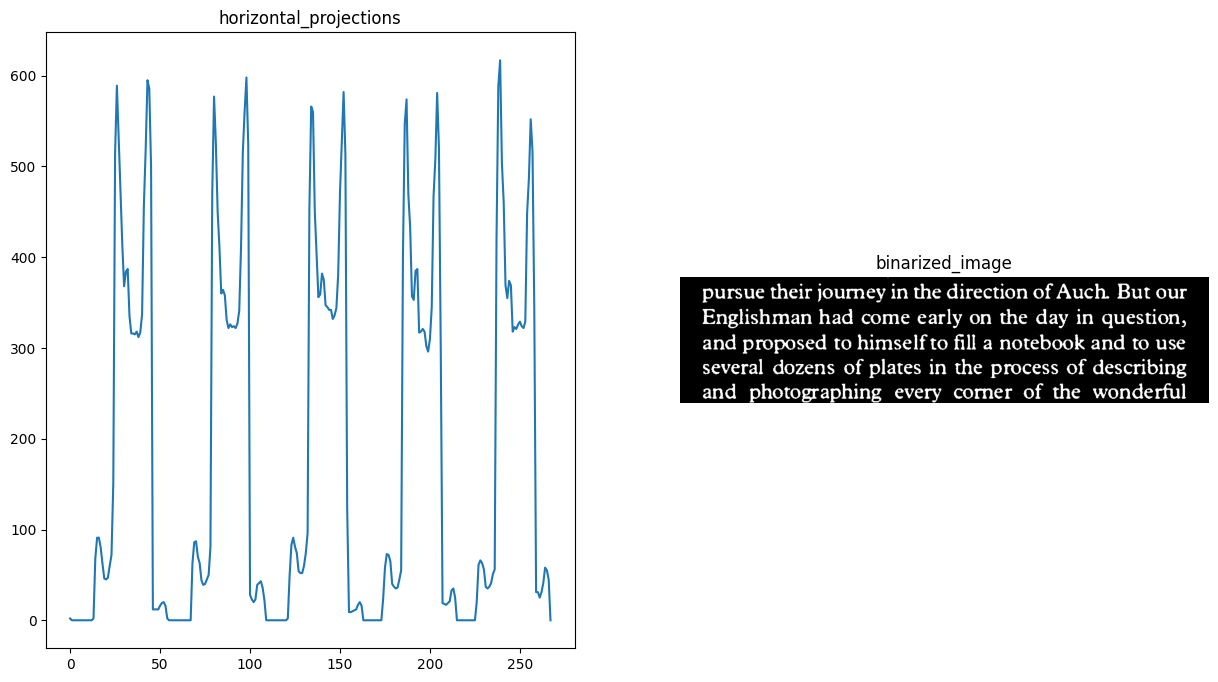

In [57]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

def binarize_image(image):
    threshold = threshold_otsu(img)
    return image < threshold
    
binarized_image = binarize_image(img)
hpp = horizontal_projections(binarized_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binarized_image, cmap="gray")

plt.show()

As you can see, where there were more white spaces there are peaks in the graph. We will use this information further to locate the regions where we can find the seperation line using the A* algorithm.

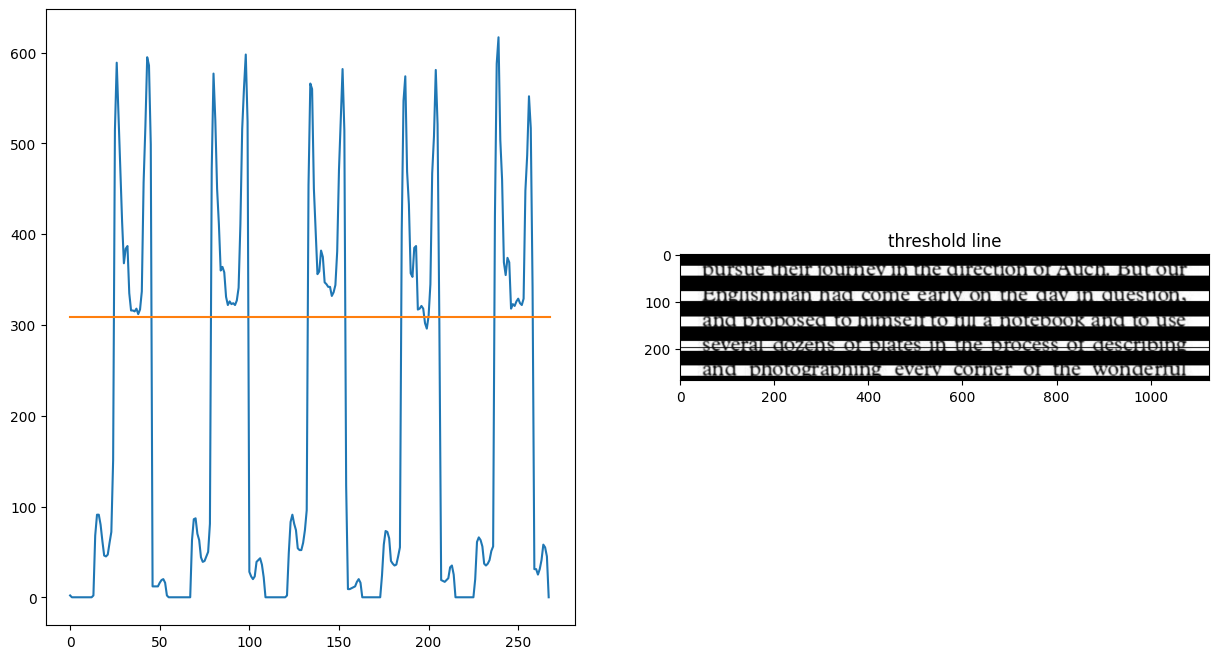

In [58]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):
    
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()


The threshold value helped us pick the probably white regions from the image. 
The black regions indicate where we would need to run our path planning algorithm for line segmentation.

In [59]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 10]
print("peak groups found", len(peak_groups))

peak groups found 5


In [61]:
#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

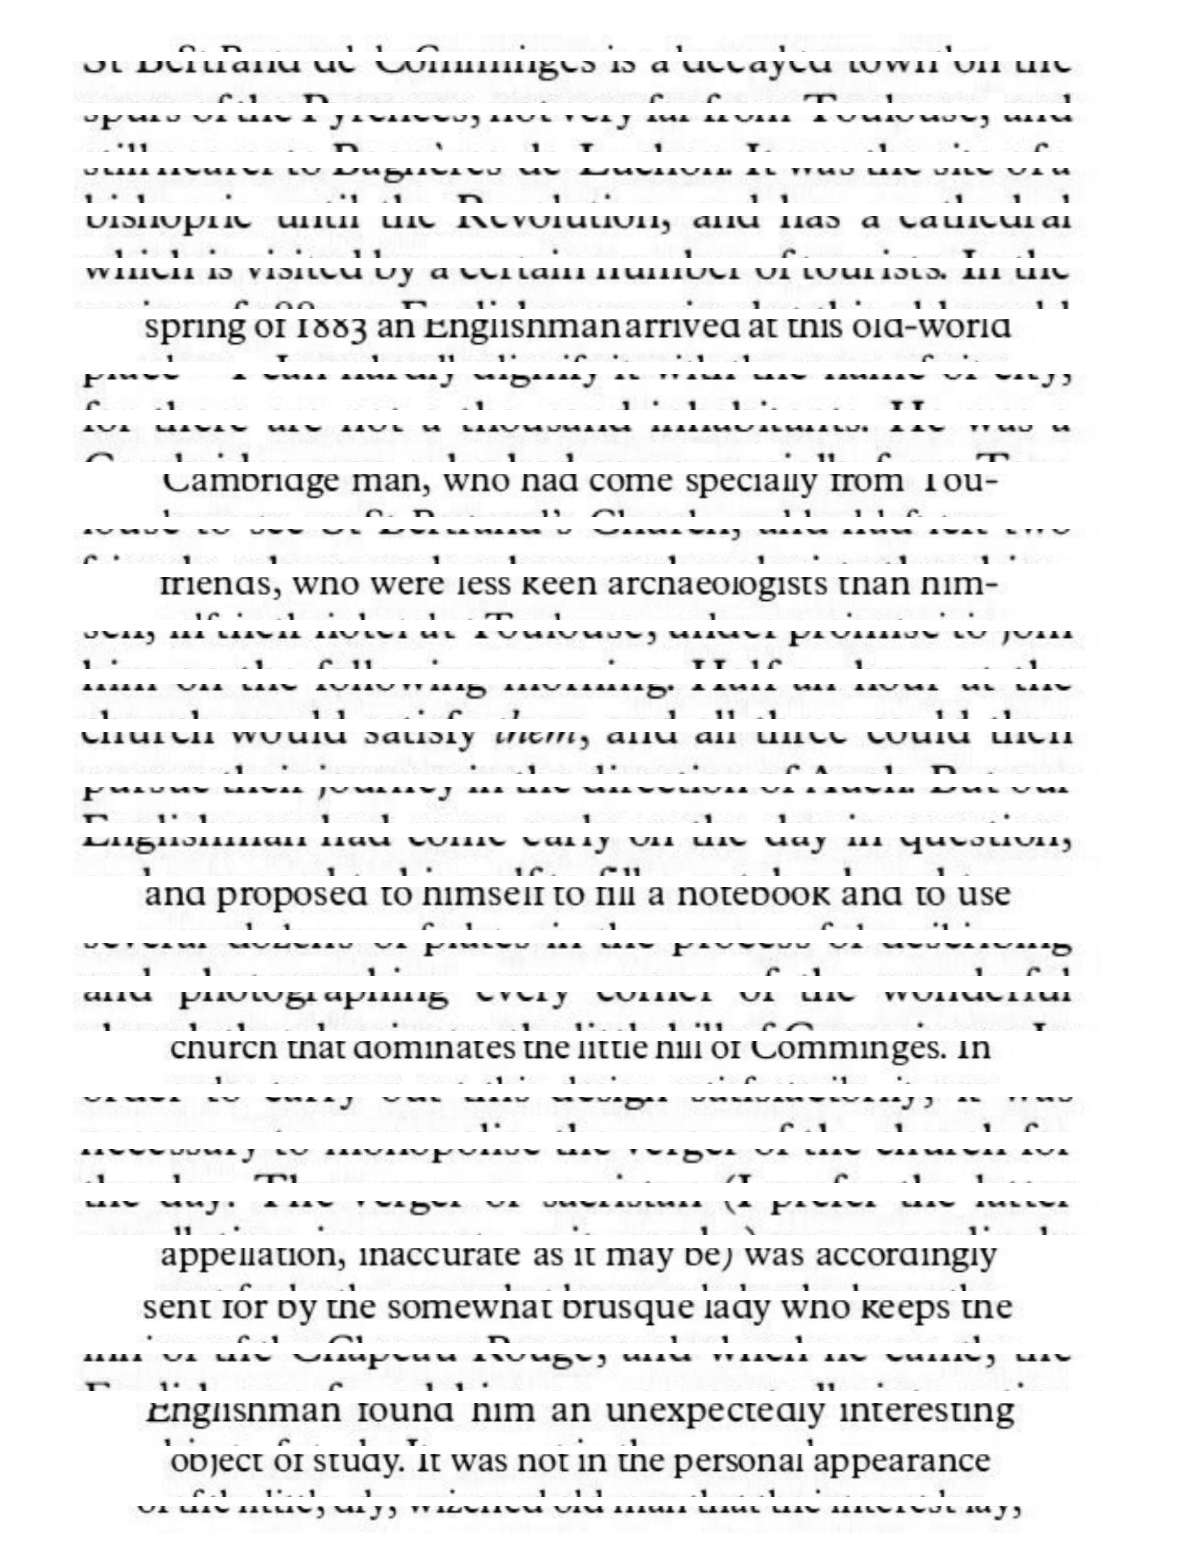

In [7]:
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [62]:
# now that everything is cleaner, its time to segment all the lines using the A* algorithm
def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary * 1
    return binary

binary_image = get_binary(img)
segment_separating_lines = []
for i, sub_image_index in enumerate(peak_groups):
    nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    offset_from_top = sub_image_index[0]
    path[:,0] += offset_from_top
    segment_separating_lines.append(path)

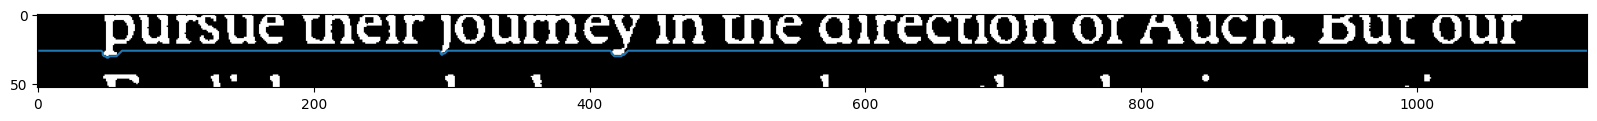

In [63]:
# visualize a sample
cluster_of_interest = peak_groups[1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot(path[:,1], path[:,0])

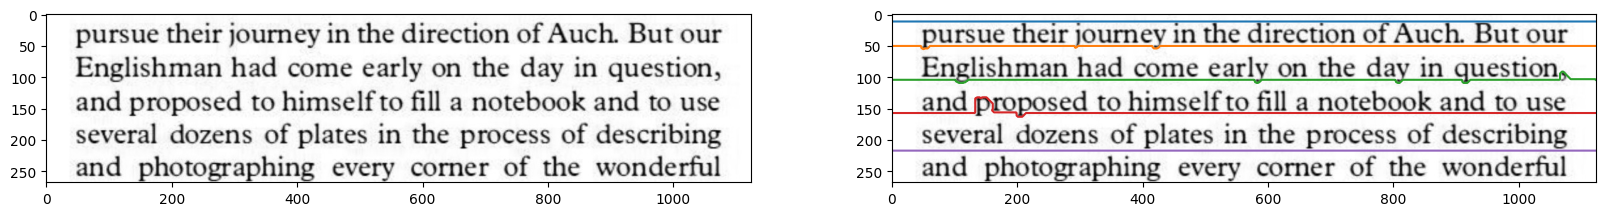

In [64]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in segment_separating_lines:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

### Lets divide the image now by the line segments passing through the image

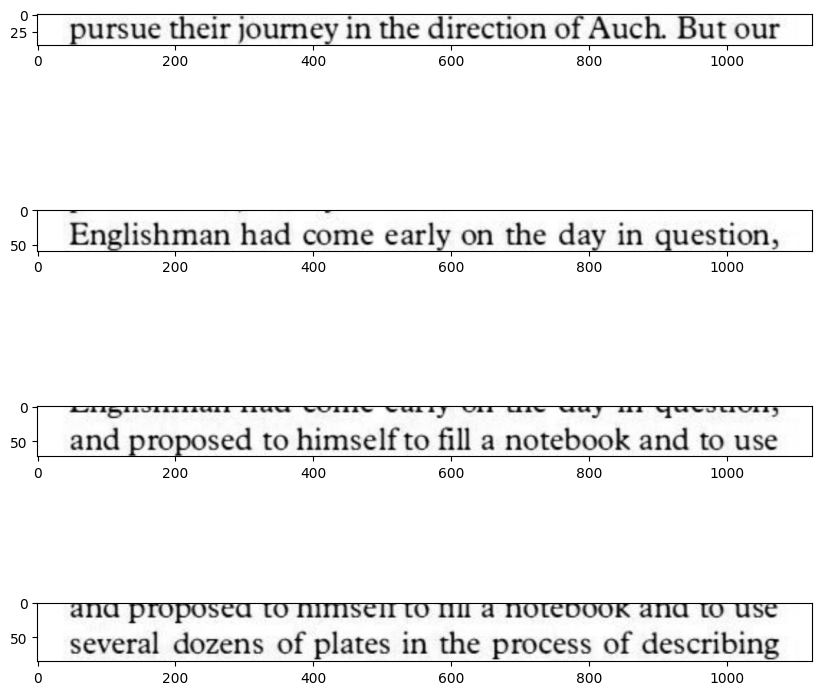

In [65]:
# TODO: the below splitting image algorithm is too simple
# I need to write a cleaner one.

seperated_images = []
for index, line_segments in enumerate(segment_separating_lines):
    if index < len(segment_separating_lines)-1:
        lower_line = np.min(segment_separating_lines[index][:,0])
        upper_line = np.max(segment_separating_lines[index+1][:,0])
        seperated_images.append(img[lower_line:upper_line])

# visualize it
fig, ax = plt.subplots(figsize=(10,10), nrows=len(seperated_images))
for index, line_image in enumerate(seperated_images):
    ax[index].imshow(line_image, cmap="gray")

plt.show()

### now that I have the lines, I can now divide these lines into words.

Ref: https://github.com/muthuspark/ml_research/blob/master/Separate%20words%20in%20a%20line%20using%20VPP.ipynb

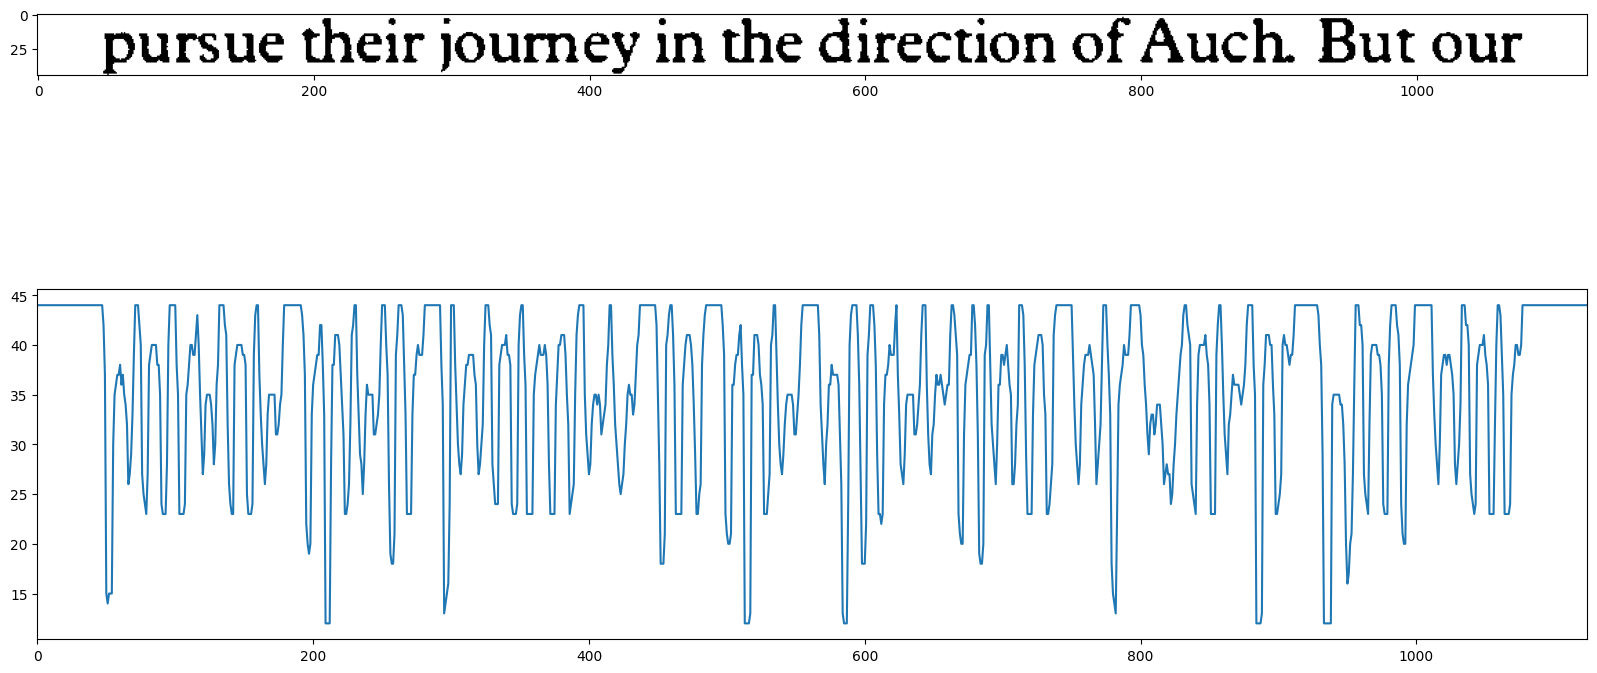

In [66]:
from skimage.filters import threshold_otsu

#binarize the image, guassian blur will remove any noise in the image
first_line = seperated_images[0]
thresh = threshold_otsu(first_line)
binary = first_line > thresh

# find the vertical projection by adding up the values of all pixels along rows
vertical_projection = np.sum(binary, axis=0)

# plot the vertical projects
fig, ax = plt.subplots(nrows=2, figsize=(20,10))
plt.xlim(0, first_line.shape[1])
ax[0].imshow(binary, cmap="gray")
ax[1].plot(vertical_projection)

In [76]:
height = first_line.shape[0]

## we will go through the vertical projections and 
## find the sequence of consecutive white spaces in the image
whitespace_lengths = []
whitespace = 0
for vp in vertical_projection:
    if vp == height:
        whitespace = whitespace + 1
    elif vp != height:
        if whitespace != 0:
            whitespace_lengths.append(whitespace)
        whitespace = 0 # reset whitepsace counter. 

print("whitespaces:", whitespace_lengths)
avg_white_space_length = np.mean(whitespace_lengths)
print("average whitespace lenght:", avg_white_space_length)

whitespaces: [48, 3, 5, 4, 2, 13, 2, 3, 3, 12, 3, 3, 2, 4, 2, 12, 2, 12, 2, 12, 4, 3, 1, 3, 2, 2, 2, 3, 12, 3, 7, 2, 2, 4, 17, 3, 4, 13, 3, 2]
average whitespace lenght: 6.025


In [72]:
## find index of whitespaces which are actually long spaces using the avg_white_space_length
whitespace_length = 0
divider_indexes = []
for index, vp in enumerate(vertical_projection):
    if vp == height:
        whitespace_length = whitespace_length + 1
    elif vp != height:
        if whitespace_length != 0 and whitespace_length > avg_white_space_length:
            divider_indexes.append(index-int(whitespace_length/2))
            whitespace_length = 0 # reset it
            
print(divider_indexes)

[24, 97, 183, 261, 287, 349, 440, 490, 560, 604, 676, 743, 795, 878, 921, 983, 1006]


In [73]:
# lets create the block of words from divider_indexes
divider_indexes = np.array(divider_indexes)
dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))

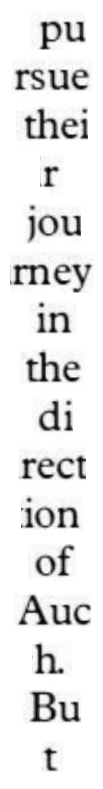

In [74]:
# now plot the findings
fig, ax = plt.subplots(nrows=len(dividers), figsize=(5,10))
for index, window in enumerate(dividers):
    ax[index].axis("off")
    ax[index].imshow(first_line[:,window[0]:window[1]], cmap="gray")